In [1]:
import os
import pandas as pd
from pathlib import Path
import numpy as np

In [2]:
# from Bio import SeqIO
# from Bio.Seq import Seq  # Import the Seq class
# from Bio.SeqRecord import SeqRecord  # Import the SeqRecord class for creating sequence records
# from collections import defaultdict

In [3]:
proj_dir="/master/nplatt/schisto_aim_panel"
results_dir=f"{proj_dir}/results"

In [4]:
info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)
info_df.head()

,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,Country,Locality,Latitude,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,angola_cota_57,MCF03050E0612,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907442,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,76.6,32.96,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
1,angola_cota_58,MCF03050E0613,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907441,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,71.6,32.83,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
2,angola_cota_59,MCF03050E0614,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907440,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,66.5,25.61,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
3,angola_icau_60,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907439,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,56.7,25.73,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
4,angola_icau_61,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907438,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,75.3,30.40,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN


# Prep Raw Data

In [5]:
os.chdir(f"{proj_dir}/data")

In [6]:
!cp ~/sch_hae_scan/results/filter_genotypes/scan_snvs.vcf.gz* .

## Filter the VCF file

In [7]:
Path(f"{results_dir}/prep_vcf").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/prep_vcf")

In [8]:
#which samples to exclude
info_df.loc[info_df["Final SNV Dataset"] == True]["Library ID"].to_csv("samples.include.list", sep=",", header=False, index=False)
!cat samples.include.list | wc -l

163


In [9]:
%%bash

conda run -n popgen --cwd . --live-stream\
    vcftools \
        --gzvcf ../../data/scan_snvs.vcf.gz \
        --maf 0.05 \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --keep samples.include.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >autosomes_maf05.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
/../data/scan_snvs.vcf.gz
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
1--chr NC_067199.
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--keep samples.include.list
FO-allode-IN
	--maf 0.05
	--recode
	--stdout

Using zlib version: 1.3.1
ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the sa

In [10]:
%%bash

conda run -n popgen --live-stream \
    plink2 \
        --vcf autosomes_maf05.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out ld

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to ld.log.
Options in effect:
allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out ld
  --vcf autosomes_maf05.vcf

tart time: Thu Mar  6 17:53:57 2025
iB for main RAM detected, ~1017340 available; reserving 515643 M
workspace.
Using up to 192 threads (change this with --threads).
--vcf: 5972982 variants scanned.
--vcf: ld-temporary.pgen + ld-temporary.pvar.zst + ld-temporary.psam written.
s, 0 males, 163 ambiguous; 163 founders) loaded from
ld-temporary.psam.
 ld-temporary.pvar.zst. from
Note: No phenotype data present.
done.lating allele frequencies... 0%
5591481/5972982 variants removed.ds): 0%
Variant lists written to ld.prune.in and ld.prune.out .
End time: Thu Mar  6 17:54:58 2025


In [11]:
%%bash

conda run -n vcftools --live-stream \
    vcftools \
        --vcf autosomes_maf05.vcf \
        --exclude ld.prune.out \
        --recode \
        --recode-INFO-all \
        --stdout \
        >scan_autosomes_maf05_ld.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
somes_maf05.vcf
	--recode-INFO-all
	--recode
	--exclude ld.prune.out
	--stdout

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each ALT allele, in the same order as l

## Reduce the number of samples to a development and test data sets

In [ ]:
# info_df.loc[ info_df["Final SNV Dataset"] == True]["Population Assignment"].value_counts()



I want to randomly select 50 northern samples, 50 southern samples and 15 S. bovis for the "panel" and then save the remaining to be in the test



In [ ]:
# # Define the sample sizes for each population
# sample_sizes = {"S. haematobium (northern)": 50, 
#                 "S. haematobium (southern)": 50, 
#                 "S. bovis": 15}

# # Sample the specified number of individuals from each population
# panel_df = pd.concat(
#     [info_df[info_df["Population Assignment"] == pop].sample(n=size, random_state=42)
#      for pop, size in sample_sizes.items() if pop in info_df["Population Assignment"].values]
# )

# panel_df.reset_index(drop=True, inplace=True)
# panel_df["Library ID"].to_csv("panel.samples.list", sep=",", header=False, index=False)
# panel_df.to_csv("panel.df.csv", sep=",", header=True, index=False)
# panel_df

In [ ]:
# %%bash

# conda run -n popgen --live-stream vcftools --vcf scan_snvs.ld.vcf --not-chr NC_067195.1 --keep panel.samples.list --recode --recode-INFO-all --stdout >panel.vcf

In [ ]:
# %%bash

# conda run -n popgen --live-stream vcftools --vcf scan_snvs.ld.vcf --not-chr NC_067195.1 --remove panel.samples.list --recode --recode-INFO-all --stdout >test.vcf

# PCA

In [180]:
Path(f"{results_dir}/pca").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/pca")

In [13]:
# info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)
# panel_df=pd.read_csv(f"{results_dir}/split_data_vcf/panel.df.csv", sep=",", header=0)
# panel_df

In [14]:
%%bash
conda run -n popgen --cwd . --live-stream\
    plink2 \
        --threads 12 \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --pca 10 allele-wts \
        --double-id \
        --allow-extra-chr \
        --out pca

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
Logging to pca.log.
Options in effect:
-allow-extra-chr
  --double-id
  --out pca
  --pca 10 allele-wts
  --threads 12
scan_autosomes_maf05_ld.vcf

Start time: Thu Mar  6 17:58:34 2025
 available; reserving 515643 MiB for main
workspace.
ads). up to 12 threads (change this with --thre
--vcf: 381501 variants scanned.
--vcf: pca-temporary.pgen + pca-temporary.pvar.zst + pca-temporary.psam
written.
ales, 0 males, 163 ambiguous; 163 founders) loaded from
pca-temporary.psam.
rom pca-temporary.pvar.zst.
Note: No phenotype data present.
done.lating allele frequencies... 0%
done.ructing GRM: 0%
done.cting for missingness... 0%
done.cting eigenvalues and eigenvectors... 
--pca: Allele weights written to pca.eigenvec.allele .
nvec , and eigenvalues written toa.eige
pca.eigenval .
End time: Thu Mar  6 17:58:41 2025


In [15]:
#get eigen values and sample labels
pca_df=pd.read_csv("pca.eigenvec", sep="\t", header=0)
pca_df=pca_df.drop("#FID", axis=1)

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', left_on="IID", right_on='Library ID')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["Country"].astype(str)

countries = sorted(pca_df["country"].unique().astype(str))
pca_df.to_csv("pca_df.csv", sep=",", header=True, index=False)
pca_df


,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments,country
0,NG_au_1.2,-0.193788,0.034904,-0.000030,0.007716,0.004214,-0.001483,-0.003820,-0.014784,-0.056267,...,adult worm (natural),55.6,20.53,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
1,NG_au_2.10,-0.192712,0.034114,-0.000016,0.008737,0.004191,0.000039,-0.004853,-0.012376,-0.063461,...,adult worm (natural),52.1,23.15,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
2,NG_au_2.13,-0.193488,0.034479,-0.000407,0.005152,0.004661,0.001240,-0.006628,-0.013438,-0.061754,...,adult worm (natural),53.0,23.30,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
3,NG_au_2.5,-0.192770,0.034375,0.001173,0.001757,0.005212,0.001661,-0.002561,-0.005953,-0.057693,...,adult worm (natural),58.1,24.73,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
4,NG_au_2.6,-0.191722,0.034577,-0.000658,0.008808,0.005192,0.000453,-0.003978,-0.019422,-0.066838,...,adult worm (natural),62.6,27.05,True,NaN,0.00%,Texas Biomedical Research Institute,TxBiomed Nigeria 2019 (Egie Elisha Enabulele),Adult worms were collected directly from cattl...,Nigeria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158,niger_libore_166,0.019183,-0.080569,-0.019166,-0.068836,0.015894,-0.087431,-0.030895,-0.041804,-0.014130,...,cercariae,81.6,41.80,True,NaN,96.11%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
159,niger_libore_167,0.020423,-0.080046,-0.008740,-0.064435,0.025870,-0.069314,-0.002363,-0.010881,-0.027030,...,cercariae,63.2,31.23,True,NaN,95.97%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
160,niger_libore_168,0.018833,-0.078780,-0.017340,-0.061889,0.005610,-0.040905,0.000884,-0.060515,-0.057258,...,cercariae,72.4,39.19,True,NaN,95.78%,SCAN,SCORE Niger non-SCORE site,NaN,Niger
161,niger_libore_169,0.020519,-0.074870,-0.018572,-0.053636,0.014773,-0.056789,0.007042,-0.014465,-0.054662,...,cercariae,95.9,50.42,True,NaN,95.79%,SCAN,SCORE Niger non-SCORE site,NaN,Niger


In [61]:
load_df = pd.read_csv("pca.eigenvec.allele", sep="\t", header=0)
load_df

,#CHROM,ID,REF,ALT,A1,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,NC_067196.1,NC_067196.1:124178,G,A,G,0.006183,-0.357448,-0.361962,-0.660223,0.133347,-1.017570,-0.234786,-0.792458,-0.378462,0.653776
1,NC_067196.1,NC_067196.1:124178,G,A,A,-0.006183,0.357448,0.361962,0.660223,-0.133347,1.017570,0.234786,0.792458,0.378462,-0.653776
2,NC_067196.1,NC_067196.1:124348,T,C,T,0.722871,-0.075344,-0.010245,0.137878,0.043088,-0.400753,-0.020437,-0.195817,-0.077878,-0.013758
3,NC_067196.1,NC_067196.1:124348,T,C,C,-0.722871,0.075344,0.010245,-0.137878,-0.043088,0.400753,0.020437,0.195817,0.077878,0.013758
4,NC_067196.1,NC_067196.1:147062,C,T,C,0.011960,0.165288,-0.739370,-0.498169,-0.579757,-0.129999,-0.159289,-0.211183,-0.521566,-0.245383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762997,NC_067202.1,NC_067202.1:19478217,C,T,T,0.171237,-0.153556,0.569210,0.232004,-0.624436,-0.035646,-0.263980,0.095318,0.383560,-0.269444
762998,NC_067202.1,NC_067202.1:19478231,C,A,C,0.121050,0.553264,-1.028450,-0.275237,-1.067260,0.137823,0.077264,0.008584,-0.163184,0.673963
762999,NC_067202.1,NC_067202.1:19478231,C,A,A,-0.121050,-0.553264,1.028450,0.275237,1.067260,-0.137823,-0.077264,-0.008584,0.163184,-0.673963
763000,NC_067202.1,NC_067202.1:19478762,C,G,C,0.112333,0.645555,-0.255612,-0.166213,0.965373,0.572820,-0.042035,0.121385,0.374986,-0.301796


In [202]:
max_pcs = 2
n_snvs_per_pc = 500

%env MAX_PCS=$max_pcs
%env N_SNVS=$n_snvs_per_pc

# Dictionary to store top variants for each PC
top_variants_per_pc = {}

# Iterate over the first six PCs
for i in range(1, max_pcs + 1):  # Assuming PCs start from column index 1
    pc_name = f"PC{i}"  # Get column name for reference
    top_variants_per_pc[pc_name] = load_df.nlargest(n_snvs_per_pc, pc_name)

# Combine all selected variants into a single DataFrame
top_variants_all_pcs = pd.concat(top_variants_per_pc.values()).drop_duplicates()

top_variants_all_pcs.to_csv(f"top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.csv", sep=",", header=True, index=False)
top_variants_all_pcs["ID"].to_csv(f"top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.list", sep=",", header=True, index=False)
top_variants_all_pcs

env: MAX_PCS=2
env: N_SNVS=100


,#CHROM,ID,REF,ALT,A1,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
369327,NC_067198.1,NC_067198.1:12006234,T,C,C,1.048470,-0.344782,-0.013033,0.064940,-0.019233,-0.029859,-0.082414,-0.090633,-0.034923,0.011968
263265,NC_067197.1,NC_067197.1:23785770,T,A,A,1.047020,-0.343836,-0.014058,0.048204,-0.011810,-0.034988,-0.194489,-0.148372,-0.059154,0.034145
729413,NC_067202.1,NC_067202.1:6563502,A,G,G,1.047020,-0.343836,-0.014058,0.048204,-0.011810,-0.034988,-0.194489,-0.148372,-0.059154,0.034145
142133,NC_067196.1,NC_067196.1:65368267,A,G,G,1.046700,-0.344433,-0.019021,0.079592,-0.013006,-0.054821,-0.116214,-0.169286,-0.062405,0.020334
744313,NC_067202.1,NC_067202.1:14983871,T,C,C,1.046010,-0.352646,-0.025618,0.069289,-0.045544,-0.020700,-0.124247,-0.175318,-0.053519,0.043498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139004,NC_067196.1,NC_067196.1:63872123,A,G,A,-0.264377,1.487860,-0.181781,-0.010835,0.458970,0.137665,0.366238,0.212139,0.075735,0.102748
514202,NC_067199.1,NC_067199.1:29396798,A,G,A,0.497423,1.487550,0.625184,0.120789,-0.136099,-0.182959,0.415511,-0.061821,0.069625,0.031330
513808,NC_067199.1,NC_067199.1:29349304,C,A,C,0.430807,1.487280,0.675361,0.009899,-0.326720,-0.162460,-0.187893,-0.204554,0.336991,0.127204
465672,NC_067199.1,NC_067199.1:8133484,T,C,T,0.155723,1.487160,0.105910,0.150624,0.208206,-0.087375,0.442297,0.307464,-0.235159,0.126518


In [203]:
%%bash

conda run -n popgen --cwd . --live-stream\
    vcftools \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --snps top_variants_pc1-${MAX_PCS}_n${N_SNVS}.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >top_variants_pc1-${MAX_PCS}_n${N_SNVS}.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--recode-INFO-all
	--recode
t--snps top_variants_pc1-2_n100.lis
	--stdout

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each AL

In [204]:
%%bash

conda run -n popgen --cwd . --live-stream\
    plink2 \
        --threads 12 \
        --vcf top_variants_pc1-${MAX_PCS}_n${N_SNVS}.vcf \
        --pca 10 \
        --double-id \
        --allow-extra-chr \
        --out pca.top_variants_pc1-${MAX_PCS}_n${N_SNVS}

PLINK v2.00a5.12LM 64-bit Intel (25 Jun 2024)  www.cog-genomics.org/plink/2.0/
urcell, Christopher Chang   GNU General Public License v3
.ogging to pca.top_variants_pc1-2_n100.log
Options in effect:
  --allow-extra-chr
  --double-id
  --out pca.top_variants_pc1-2_n100
0 --pca 1
  --threads 12
  --vcf top_variants_pc1-2_n100.vcf

Start time: Fri Mar  7 16:01:51 2025
iB RAM detected, ~1017621 available; reserving 515643 MiB for main
workspace.
 (change this with --threads).
--vcf: 200 variants scanned.
--vcf: pca.top_variants_pc1-2_n100-temporary.pgen +
+ca.top_variants_pc1-2_n100-temporary.pvar.zst 
pca.top_variants_pc1-2_n100-temporary.psam written.
; 163 founders) loaded fromales, 163 ambiguous
pca.top_variants_pc1-2_n100-temporary.psam.
.top_variants_pc1-2_n100-temporary.pvar.zst.
Note: No phenotype data present.
quencies... done.e
done.ructing GRM: 0%
done.cting for missingness... 0%
done.cting eigenvalues and eigenvectors... 
--pca: Eigenvectors written to pca.top_variants_pc1-2_n1

In [205]:
#get eigen values and sample labels
pca_top_pcs_df=pd.read_csv(f"pca.top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.eigenvec", sep="\t", header=0)
pca_top_pcs_df=pca_top_pcs_df.drop("#FID", axis=1)

#merge the dataframes
pca_top_pcs_df=pca_top_pcs_df.merge(info_df, how='left', left_on="IID", right_on='Library ID')
pca_top_pcs_df.to_csv(f"pca.top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.df.csv", sep=",", header=True, index=False)
# pca_top_pcs_df


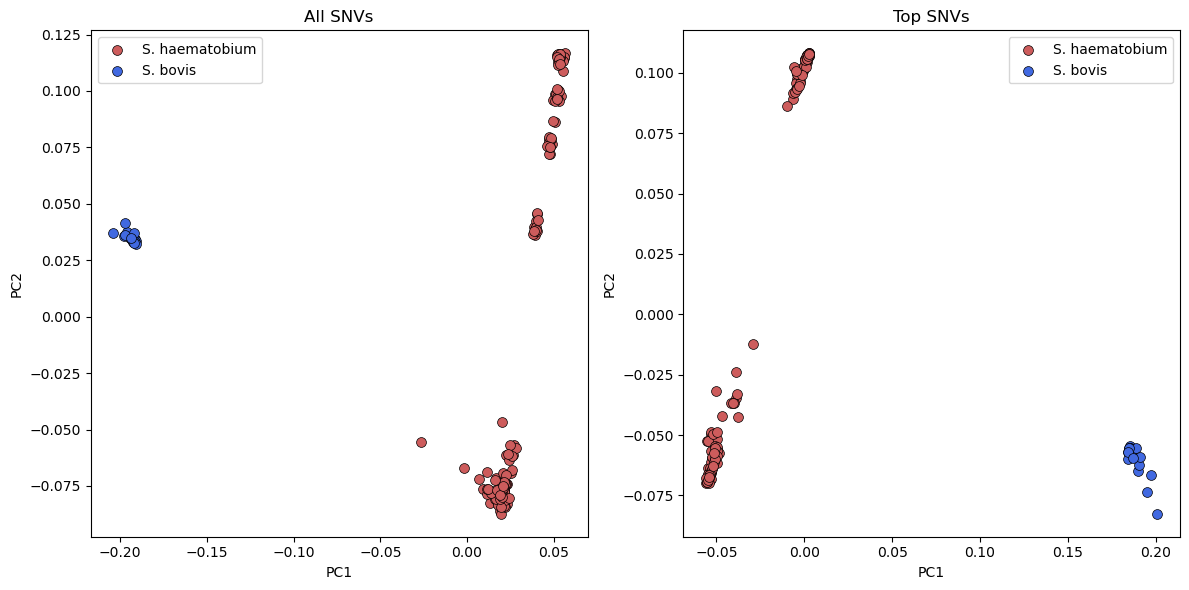

In [206]:
import matplotlib.pyplot as plt
import yaml
import pandas as pd

# Define directories
proj_dir = "/master/nplatt/schisto_aim_panel"
results_dir = f"{proj_dir}/results"

# Load data
info_df = pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",")
all_snvs_df = pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")
top_snvs_df = pd.read_csv(f"{results_dir}/pca/pca.top_variants_pc1-{max_pcs}_n{n_snvs_per_pc}.df.csv", sep=",")

# Filter for specific species
all_snvs_df = all_snvs_df[all_snvs_df["Predicted Species"].isin(["S. haematobium", "S. bovis"])]
top_snvs_df = top_snvs_df[top_snvs_df["Predicted Species"].isin(["S. haematobium", "S. bovis"])]

# Load YAML config
with open(f"{proj_dir}/code/plotting_config.yaml", "r") as config_file:
    config = yaml.safe_load(config_file)

# Create figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Subplot 1: All SNVs
for species in ["S. haematobium", "S. bovis"]:
    all_snv_data = all_snvs_df[all_snvs_df["Predicted Species"] == species]
    axes[0].scatter(
        all_snv_data["PC1"],
        all_snv_data["PC2"],
        color=config["species"][species]["color"],
        edgecolor="black",
        s=50,
        linewidths=0.5,
        label=species
    )
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].set_title("All SNVs")
axes[0].legend()

# Subplot 2: Top SNVs
for species in ["S. haematobium", "S. bovis"]:
    top_snv_data = top_snvs_df[top_snvs_df["Predicted Species"] == species]
    axes[1].scatter(
        top_snv_data["PC1"],
        top_snv_data["PC2"],
        color=config["species"][species]["color"],
        edgecolor="black",
        s=50,
        linewidths=0.5,
        label=species
    )
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].set_title("Top SNVs")
axes[1].legend()

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"pca_comparison_pc1-{max_pcs}_n{n_snvs_per_pc}.png", facecolor="white", dpi=600, bbox_inches="tight")
plt.savefig(f"pca_comparison_pc1-{max_pcs}_n{n_snvs_per_pc}.svg")

# Show plot
plt.show()

# Fst

In [17]:
Path(f"{results_dir}/fst").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/fst")

In [19]:
info_df=pd.read_csv(f"{proj_dir}/data/platt_et_al_2025_stable1.csv", sep=",", header=0)
info_df.head()

,Library ID,Museum Accession Number (NHM) or Donor ID,Predicted Species,Mitchondrial Haplotype,Population Assignment,NCBI SRA Accession,Project Citation,Country,Locality,Latitude,...,Original life-cycle stage collected,Life-cycle stage sequenced,Num Read Pairs (1e6),Coverage,Final SNV Dataset,Discordant COX1/ITS,% S. haematobium ancestry (q),Origin,Project (Collector),Comments
0,angola_cota_57,MCF03050E0612,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907442,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,76.6,32.96,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
1,angola_cota_58,MCF03050E0613,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907441,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,71.6,32.83,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
2,angola_cota_59,MCF03050E0614,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907440,Herein,Angola,Source of the Cota river,-9.26186,...,cercariae,cercariae,66.5,25.61,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
3,angola_icau_60,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907439,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,56.7,25.73,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN
4,angola_icau_61,MCF03050E0615,S. haematobium,S. haematobium,S. haematobium (southern),SRR11907438,Herein,Angola,Icau Wando village,-8.6451,...,miracidia,miracidia,75.3,30.40,True,NaN,100.00%,SCAN,Angola malacology survey 2013- NNTDCP/CIS and ...,NaN


In [20]:
info_df.loc[info_df["Predicted Species"] == 'S. haematobium', "Library ID"].to_csv("shae.list", sep=",", header=False, index=False)
info_df.loc[info_df["Predicted Species"] == 'S. bovis', "Library ID"].to_csv("sbov.list", sep=",", header=False, index=False)

In [21]:
%%bash

conda run -n popgen --live-stream \
    vcftools \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --weir-fst-pop shae.list \
        --weir-fst-pop sbov.list


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--weir-fst-pop shae.list
	--weir-fst-pop sbov.list
.listep shae
	--keep sbov.list

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for

In [22]:
fst_df=pd.read_csv("out.weir.fst", sep="\t", header=0)
fst_df

,CHROM,POS,WEIR_AND_COCKERHAM_FST
0,NC_067196.1,124178,0.026728
1,NC_067196.1,124348,0.848705
2,NC_067196.1,147062,-0.015993
3,NC_067196.1,147068,0.000732
4,NC_067196.1,147073,0.044099
...,...,...,...
381496,NC_067202.1,19477842,0.084907
381497,NC_067202.1,19478168,0.973279
381498,NC_067202.1,19478217,0.325318
381499,NC_067202.1,19478231,0.010759


In [26]:
fst_df = fst_df.loc[fst_df["WEIR_AND_COCKERHAM_FST"]>0].reset_index(drop=True)
fst_df.to_csv("fst_df.csv", sep=",", header=True, index=False)
fst_df

,CHROM,POS,WEIR_AND_COCKERHAM_FST
0,NC_067196.1,124178,0.026728
1,NC_067196.1,124348,0.848705
2,NC_067196.1,147068,0.000732
3,NC_067196.1,147073,0.044099
4,NC_067196.1,147161,0.007621
...,...,...,...
343761,NC_067202.1,19477842,0.084907
343762,NC_067202.1,19478168,0.973279
343763,NC_067202.1,19478217,0.325318
343764,NC_067202.1,19478231,0.010759


In [32]:
fst_df.loc[fst_df["WEIR_AND_COCKERHAM_FST"]>0.95]

,CHROM,POS,WEIR_AND_COCKERHAM_FST
2668,NC_067196.1,2623398,0.951922
2669,NC_067196.1,2662673,0.978441
2701,NC_067196.1,2710808,0.985495
2742,NC_067196.1,2736479,0.951694
2783,NC_067196.1,2753200,0.992392
...,...,...,...
343464,NC_067202.1,19329802,0.953022
343667,NC_067202.1,19457214,0.960472
343703,NC_067202.1,19465685,0.957880
343729,NC_067202.1,19470114,0.985899


# InfoCalc

In [140]:
Path(f"{results_dir}/infocalc").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/infocalc")

In [ ]:
%%bash 

cd /master/nplatt/schisto_aim_panel/bin
https://rosenberglab.stanford.edu/software/infocalc.tar
tar -xvf infocalc.tar

In [107]:
%%bash

conda run -n popgen --live-stream bash -c "
    vcftools \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --remove-indv margrebowiei_zambia_ERR310940 \
        --recode \
        --recode-INFO-all \
        --stdout | bgzip > to_infocalc.vcf.gz"


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--recode-INFO-all
	--recode
	--stdout
ei_zambia_ERR310940rebowi

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each ALT allele, 

In [125]:
!conda run -n popgen bcftools query -l to_infocalc.vcf.gz >samples.list

samples_df = pd.read_csv("samples.list", sep="\t", header=None, names=["Library ID"])

map_df = samples_df.merge(info_df[["Library ID", "Predicted Species"]], on="Library ID", how="left")

# Replace spaces with underscores in Predicted Species
map_df["Predicted Species"] = map_df["Predicted Species"].str.replace(". ", "_", regex=False)

# Save to output file
map_df.to_csv("sample.map", sep=" ", index=False, header=False)

In [ ]:
./VCF_to_Infocalc.py to_infocalc.vcf.gz sample.map >infocalc.input.tsv

In [ ]:
../../bin/infocalc -i infocalc.input.tsv -o infocalc.tsv

In [154]:
in_df=pd.read_csv("infocalc.tsv", sep="\t", header=0, skipfooter=2, engine="python")
in_df.columns = i_df.columns.str.replace(" ", "", regex=False)
in_df.to_csv("In_df.csv", sep=",", header=True, index=False)
in_df

,Locus,I_n,I_a,ORCA[1-allele],ORCA[2-allele]
0,NC_067196.1:10000002,0.566896,0.164760,0.966102,0.997702
1,NC_067196.1:10000163,0.220649,0.063786,0.754425,0.879386
2,NC_067196.1:10000702,0.218000,0.063000,0.752033,0.877024
3,NC_067196.1:10001140,0.056993,0.016059,0.577519,0.643020
4,NC_067196.1:10001242,0.215762,0.062335,0.750000,0.875000
...,...,...,...,...,...
381496,NC_067202.1:9987708,0.648199,0.184793,0.991071,0.999841
381497,NC_067202.1:9989293,0.157976,0.045278,0.693925,0.812636
381498,NC_067202.1:998984,0.453419,0.138951,0.934746,0.948009
381499,NC_067202.1:9992190,0.274358,0.079789,0.800000,0.920000


In [153]:
in_df.nlargest(10000, "I_n").to_csv("top_In_df.csv", sep=",", header=True, index=False)

# Admixture

In [127]:
Path(f"{results_dir}/admixture").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/admixture")

In [128]:
%%bash

conda run -n popgen --live-stream bash -c "
    vcftools \
        --vcf ../prep_vcf/scan_autosomes_maf05_ld.vcf \
        --remove-indv margrebowiei_zambia_ERR310940 \
        --recode \
        --recode-INFO-all \
        --stdout > admixture.vcf"


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
rep_vcf/scan_autosomes_maf05_ld.vcf
	--recode-INFO-all
	--recode
	--stdout
ei_zambia_ERR310940rebowi

ted at least 2 parts in FORMAT entry: ID=PID,Number=1,Type=String,Description="Physical phasing ID information, where each unique ID within a given sample (but not across samples) connects records within a phasing group">
r,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">
conditional reference genotype confidence, encoded as a phred quality -10*log10 p(genotype call is wrong)">
llele count in genotypes, for each ALT allele, in the same order as listed">r,Description="A
ast 2 parts in INFO entry: ID=AC,Number=A,Type=Integer,Description="Allele count in genotypes, for each ALT allele, in the same order as listed">
F,Number=A,Type=Float,Description="Allele Frequency, for each ALT allele, in the same order as listed">
Frequency, for each ALT allele, 

In [138]:
%%bash

conda run -n plink --cwd . \
    plink \
        --vcf admixture.vcf \
        --out admixture \
        --double-id \
        --recode 12 \
        --allow-extra-chr

conda run -n popgen --cwd . bcftools query -l admixture.vcf >samples.list

PLINK v1.9.0-b.7.7 64-bit (22 Oct 2024)            cog-genomics.org/plink/1.9/
urcell, Christopher Chang   GNU General Public License v3
Logging to admixture.log.
t:tions in effec
  --allow-extra-chr
  --double-id
  --out admixture
  --recode 12
  --vcf admixture.vcf

MB RAM detected; reserving 515643 MB for main workspace.

--vcf: 1k variants complete.
iants complete.
--vcf: 3k variants complete.
--vcf: 4k variants complete.
e.vcf: 5k variants complet
--vcf: 6k variants complete.
--vcf: 7k variants complete.
--vcf: 8k variants complete.
variants complete.
--vcf: 10k variants complete.
--vcf: 11k variants complete.
omplete.2k variants c
--vcf: 13k variants complete.
--vcf: 14k variants complete.
--vcf: 15k variants complete.
-vcf: 16k variants complete.
--vcf: 17k variants complete.
--vcf: 18k variants complete.
variants complete.
--vcf: 20k variants complete.
--vcf: 21k variants complete.
omplete.2k variants c
--vcf: 23k variants complete.
--vcf: 24k variants complete.
--vcf: 25k vari

In [139]:
%%bash

#UNSUPERVISED 
#submit jobs to the cluster
QSUB="qsub -V -cwd -S /bin/bash -q all.q "  

for K in $(seq 2 5); do
    CMD="conda run -n popgen --live-stream admixture \
        --cv=1000 \
        -j12 \
        admixture.ped \
        $K \
        >admixutre.k$K.log"

    echo $CMD | qsub -V -cwd -S /bin/bash -q all.q  -N adm.k$K -o admixture.k$K.sge.stdout -e admixture.k$K.sge.stderr -pe smp 12
done

Your job 1443404 ("adm.k2") has been submitted
Your job 1443405 ("adm.k3") has been submitted
Your job 1443406 ("adm.k4") has been submitted
Your job 1443407 ("adm.k5") has been submitted


# VENN diagram/overlap of the 5 datasets

In [162]:
fst_df = pd.read_csv(f"{results_dir}/fst/fst_df.csv", sep=",", header=0)
in_df = pd.read_csv(f"{results_dir}/infocalc/top_In_df.csv", sep=",", header=0)
pca_df = pd.read_csv(f"{results_dir}/pca/top_variants_pc1-{max_pcs}.list", sep=",", header=0)
# adm_df = pd.read_csv(f"{results_dir}/admixture/adm_k2_df.csv", sep=",", header=0)


# in_df.nlargest(10000, "I_n").to_csv("top_In_df.csv", sep=",", header=True, index=False)

In [163]:
pca_df

,ID
0,NC_067198.1:12006234
1,NC_067197.1:23785770
2,NC_067202.1:6563502
3,NC_067196.1:65368267
4,NC_067202.1:14983871
...,...
75756,NC_067196.1:38023509
75757,NC_067202.1:18732462
75758,NC_067196.1:21025136
75759,NC_067198.1:663404


In [178]:
i = set(in_df.nlargest(5_000, "I_n")["Locus"])
p = set(pca_df["ID"])
# f = fst_df.nlargest(5_000, "WEIR_AND_COCKERHAM_FST")[["CHROM", "POS"]]
# f = set([f"{chrom}:{pos}" for chrom, pos in zip(f["CHROM"], f["POS"])])

len(i.intersection(p))

1971